In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('NASA/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

NASA/B0007.mat
NASA/README.txt
NASA/B0018.mat
NASA/B0006.mat
NASA/B0005.mat


# Introduction:
- In this notebook, I have **pre-processed ,analyzed, detected and treated several anomalies/outliers** using multiple techniques on the battery charge / discharge dataset obtained from NASA.
- I have used 5 most widely used anomalies/outliers detection techniques such as:
    - IQR based
    - DBSCAN (density based)
    - Isolation Forest
    - Local Outlier Factor (LOF)
    - Elliptical Envelope

# Problem Statement:
- NASA is experimenting on making hydrogen Fuel Cell Electric Vehicle (FCEV) for space. An FCEV is powered by a hydrogen fuel cell, which generates electric power using on-board hydrogen. On a full tank, this FCEV can go up to a claimed 600 kilometers.
- They have reached out to the **Data Science team in NASA** for helping them in understanding some parameters related to Hydrogen Fuel cell sensors. As a data scientist working in the R&D team of NASA, **you need to analyze the aging process, charge, and discharge cycle of the cell and isolate some anomalies/ instances you see in the data.**

## Data Dictionary:
- Voltage_measured: Fuel Cell terminal voltage (Volts)
- Current_measured: Fuel Cell output current (Amps)
- Temperature_measured: Fuel Cell temperature (degree C)
- Current_load: Current measured at load (Amps)
- Voltage_load: Voltage measured at load (Volts)
- Time: Time vector for the cycle (seconds)
- Capacity: Fuel Cell capacity (Ahr) for discharge till 2.7V
- Datetime: the date and time of the start of the cycle
- Ambient_temperature: Temperature in which the fuel cell is stored (degree C)
- Cycle: Charge cycle of the fuel cell

## Data Description:
- A set of four Fuel cells (# 5, 6, 7 and 18) were run through 2 different operational profiles (charge& discharge) at room temperature. Charging was carried out in a constant current (CC) mode at 1.5A until the Fuel cell voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for Fuel cell 5 6 7 and 18 respectively.
- Repeated charge and discharge cycles result in accelerated aging of the Fuel cell. The experiments were stopped when the Fuel cell reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr).

- This data can be further used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).

 - Files:

    - B0005.mat Data for Fuel cell #5

    - B0006.mat Data for Fuel cell #6

    - B0007.mat Data for Fuel cell #7

    - B0018.mat Data for Fuel cell #18


### Importing libraries:


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Converting the matlab files to csv:

In [3]:
def load_data(nm,battery): # Example of input load_data('B0006.mat','B0006')
    mat = loadmat(nm)
    #print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []
    capacity_data = []

    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge' :
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                   int(row['time'][0][1]),
                                   int(row['time'][0][2]),
                                   int(row['time'][0][3]),
                                   int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,
                                temperature_measured, current_load,
                                voltage_load, time])
                capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
                counter = counter + 1
#     print(dataset[0])
    return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [4]:
B0005_dataset, B0005_capacity = load_data('NASA/B0005.mat','B0005')
B0005_dataset['flag'] = 1

In [5]:
B0006_dataset, B0006_capacity = load_data('NASA/B0006.mat','B0006')
B0006_dataset['flag'] = 2

In [6]:
B0007_dataset, B0007_capacity = load_data('NASA/B0007.mat','B0007')
B0007_dataset['flag'] = 3

In [7]:
B0018_dataset, B0018_capacity = load_data('NASA/B0018.mat','B0018')
B0018_dataset['flag'] = 4

<Axes: >

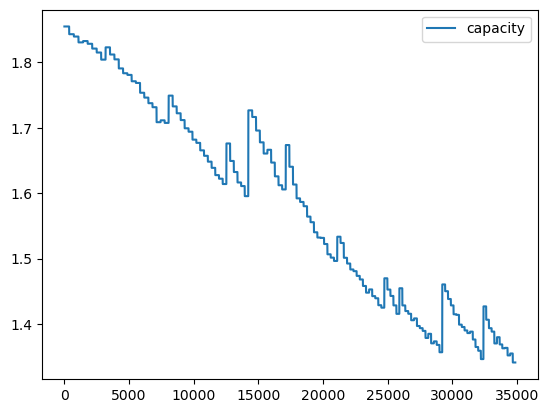

In [17]:
B0018_dataset.plot(y = "capacity")

<Axes: >

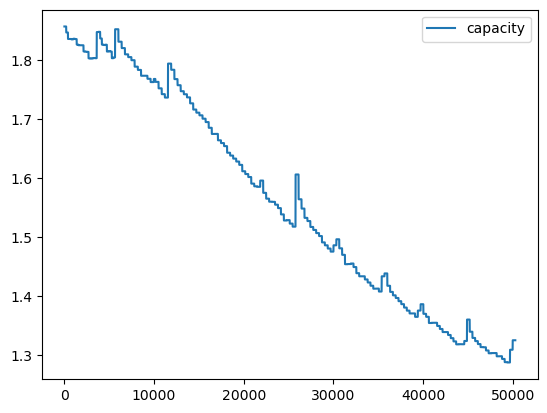

In [16]:

B0005_dataset.plot(y = "capacity")

In [8]:
fuel_cells_df = pd.concat([B0005_dataset,B0006_dataset,B0007_dataset,B0018_dataset], ignore_index = True)

In [9]:
fuel_cells_df

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,flag
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1
1,2,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1
2,3,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1
3,4,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1
4,5,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1
...,...,...,...,...,...,...,...,...,...,...,...
185716,34862,24,2008-08-20 08:37:19,1.341051,3.443760,-0.002426,35.383979,0.0006,0.000,2686.359,4
185717,34863,24,2008-08-20 08:37:19,1.341051,3.453271,-0.000981,35.179732,0.0006,0.000,2700.546,4
185718,34864,24,2008-08-20 08:37:19,1.341051,3.461963,0.000209,34.977000,0.0006,0.000,2714.640,4
185719,34865,24,2008-08-20 08:37:19,1.341051,3.469907,0.001516,34.785943,0.0006,0.000,2728.750,4


### Identification of variables and data types:

In [18]:
fuel_cells_df.shape

(185721, 11)

In [19]:
fuel_cells_df.columns

Index(['cycle', 'ambient_temperature', 'datetime', 'capacity',
       'voltage_measured', 'current_measured', 'temperature_measured',
       'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

In [20]:
fuel_cells_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cycle                 185721 non-null  int64         
 1   ambient_temperature   185721 non-null  uint8         
 2   datetime              185721 non-null  datetime64[ns]
 3   capacity              185721 non-null  float64       
 4   voltage_measured      185721 non-null  float64       
 5   current_measured      185721 non-null  float64       
 6   temperature_measured  185721 non-null  float64       
 7   current_load          185721 non-null  float64       
 8   voltage_load          185721 non-null  float64       
 9   time                  185721 non-null  float64       
 10  flag                  185721 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), uint8(1)
memory usage: 14.3 MB


### Unique values:

In [21]:
for i in fuel_cells_df.columns:
    print(i, ":" , fuel_cells_df[i].nunique())


cycle : 50285
ambient_temperature : 1
datetime : 300
capacity : 636
voltage_measured : 185721
current_measured : 185721
temperature_measured : 185721
current_load : 21
voltage_load : 1835
time : 62016
flag : 4


In [22]:
fuel_cells_df.drop('ambient_temperature', axis = 1, inplace = True)

In [23]:
fuel_cells_df

,cycle,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,flag
0,1,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1
1,2,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1
2,3,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1
3,4,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1
4,5,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1
...,...,...,...,...,...,...,...,...,...,...
185716,34862,2008-08-20 08:37:19,1.341051,3.443760,-0.002426,35.383979,0.0006,0.000,2686.359,4
185717,34863,2008-08-20 08:37:19,1.341051,3.453271,-0.000981,35.179732,0.0006,0.000,2700.546,4
185718,34864,2008-08-20 08:37:19,1.341051,3.461963,0.000209,34.977000,0.0006,0.000,2714.640,4
185719,34865,2008-08-20 08:37:19,1.341051,3.469907,0.001516,34.785943,0.0006,0.000,2728.750,4


In [24]:
fuel_cells_df.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
cycle,185721.0,23695.670797,14115.216705,1.000000,11608.000000,23216.000000,34823.000000,50285.000000
capacity,185721.0,1.574863,0.190633,1.153818,1.426025,1.559634,1.741850,2.035338
voltage_measured,185721.0,3.497219,0.251691,1.737030,3.377653,3.500859,3.655751,4.233325
current_measured,185721.0,-1.832569,0.561405,-2.029098,-2.011418,-2.009015,-1.989974,0.014306
temperature_measured,185721.0,32.378997,4.027737,22.350256,29.570621,32.355737,35.420677,42.332522
current_load,185721.0,1.465434,1.226874,-2.000000,1.998200,1.998800,1.999000,2.000000
voltage_load,185721.0,2.366494,0.751377,0.000000,2.410000,2.558000,2.718000,4.249000
time,185721.0,1546.379935,906.958628,0.000000,764.797000,1537.031000,2307.485000,3690.234000
flag,185721.0,2.375466,1.073068,1.000000,1.000000,2.000000,3.000000,4.000000


In [25]:
# Missing values:

def missingValue(df):
    #Identifying Missing data.
    total_null = df.isnull().sum().sort_values(ascending = False)
    percent = ((df.isnull().sum()/len(df))*100).sort_values(ascending = False)
    print(f"Total records in our data =  {df.shape[0]} where missing values are as follows:")

    missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
    return missing_data

In [26]:
missing_df = missingValue(fuel_cells_df)
missing_df[missing_df['Total Missing'] > 0]

Total records in our data =  185721 where missing values are as follows:


,Total Missing,In Percent


# Univariate Analysis:

In [27]:
def numerical_feat(df,colname,nrows=2,mcols=2,width=15,height=70):
    fig , ax = plt.subplots(nrows,mcols,figsize=(width,height))
    fig.set_facecolor("lightgrey")
    rows = 0
    for var in colname:
        ax[rows][0].set_title("Boxplot for Outlier Detection ", fontweight="bold")
        plt.ylabel(var, fontsize=12)
        sns.boxplot(y = df[var],color='crimson',ax=ax[rows][0])

        sns.histplot(df[var],color='purple',ax=ax[rows][1],kde=True)
        ax[rows][1].axvline(df[var].mean(), color='r', linestyle='--', label="Mean")
        ax[rows][1].axvline(df[var].median(), color='m', linestyle='-', label="Median")
        ax[rows][1].axvline(df[var].mode()[0], color='royalblue', linestyle='-', label="Mode")
        ax[rows][1].set_title("Outlier Detection ", fontweight="bold")
        ax[rows][1].legend({'Mean':df[var].mean(),'Median':df[var].median(),'Mode':df[var].mode()})
        rows += 1
    plt.show()

In [28]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

In [29]:
numerical_cols = ['capacity', 'voltage_load']

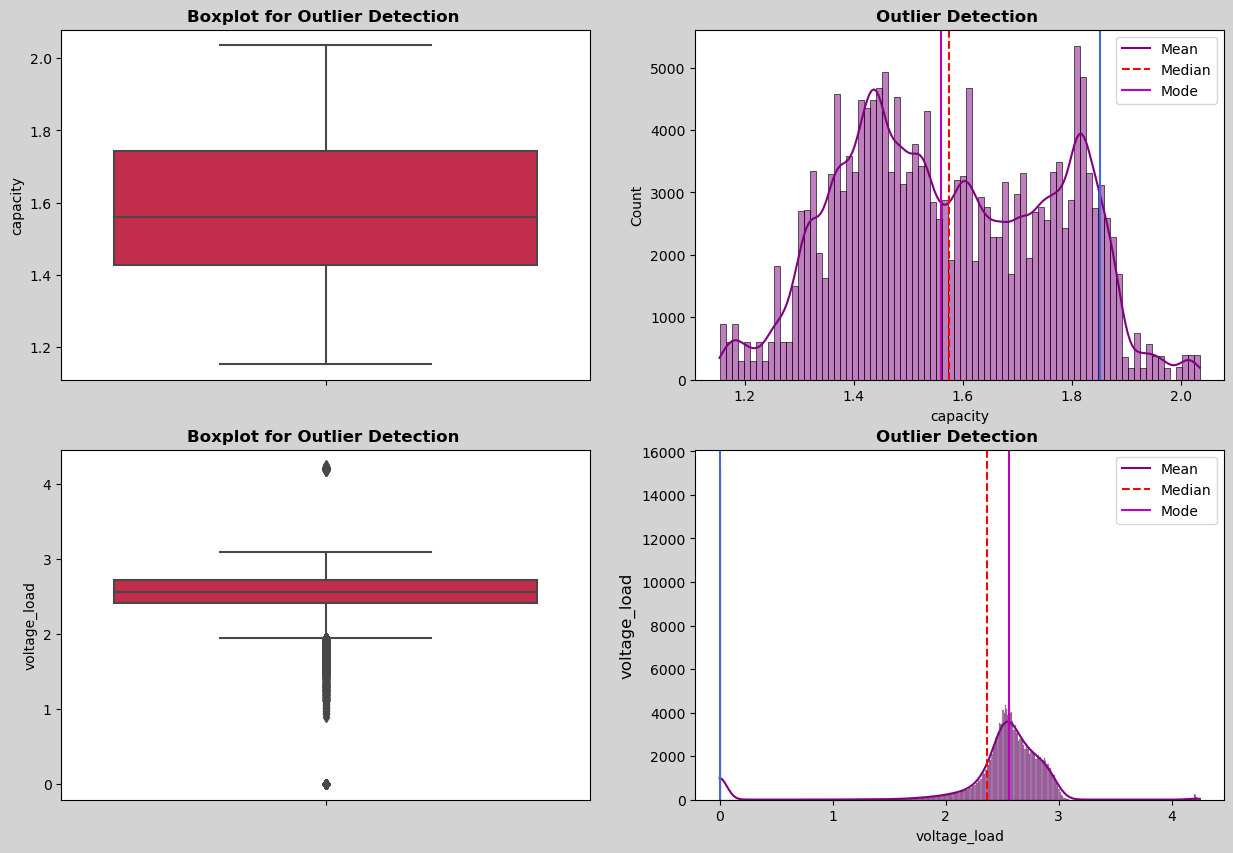

In [30]:
numerical_feat(fuel_cells_df,numerical_cols,len(numerical_cols),2,15,10)

- As we can see, the voltage load gas near normal distribution and has few outliers to the lower end.
- Whereas, capacity is multimodal distributed having almost zero outliers.

In [24]:
categorical_cols = ['flag']

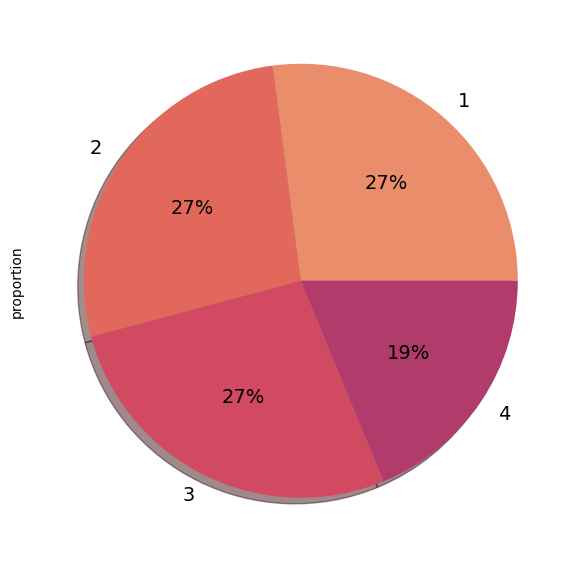

In [25]:
plt.figure(figsize = (7,8))
count = (fuel_cells_df['flag'].value_counts(normalize=True)*100)
count.plot.pie(colors = sns.color_palette("flare"),autopct='%0.0f%%',
                       textprops={'fontsize': 14},shadow = True)
plt.show()

- Battery 4 has least no. of datapoints, whereas the other three have equal no. of dp.

# Bivariate Analysis:

In [26]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

### 1. Capacity w.r.t Cycle

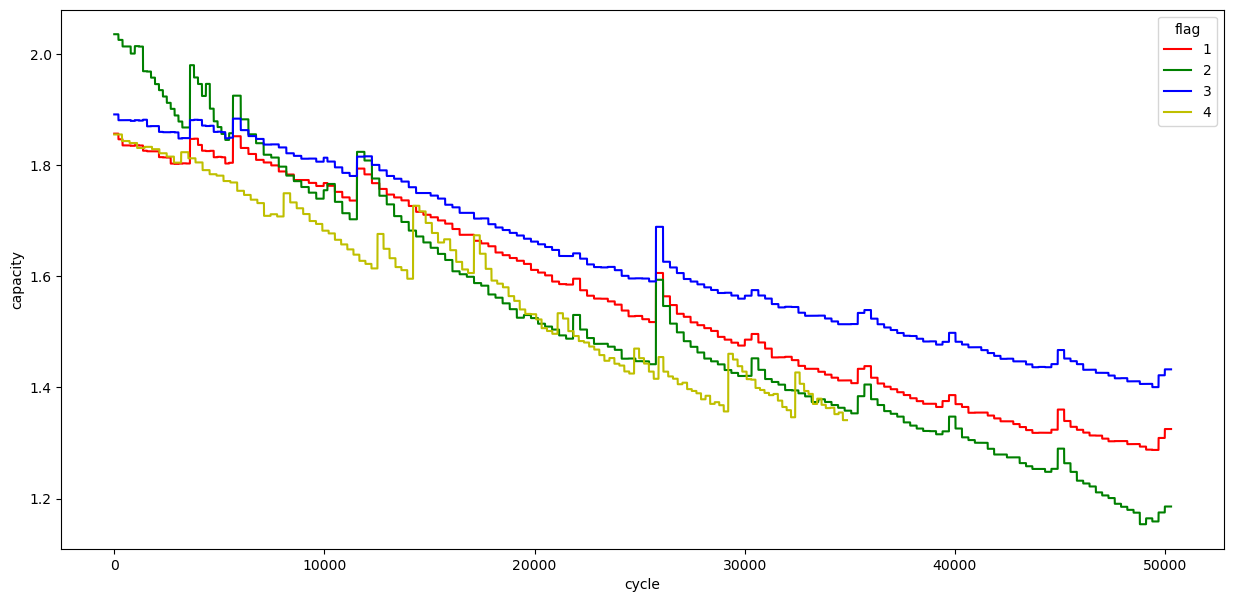

In [27]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'cycle', y = 'capacity', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- Batteries:
    - B0005.mat Data for Fuel cell #5
    - B0006.mat Data for Fuel cell #6
    - B0007.mat Data for Fuel cell #7
    - B0018.mat Data for Fuel cell #18



- As the cycle increases, the batterry capacities is showing a decreasing trend.
- Capacity of batteries decrease as no. of cycles of battery usage increases
- Battery B0006 is having the largest capacity when it's new. Whereas B0018 and B0007 is having the least capacity when it's unused.
- Over a period of time, B0006 shows much more deteriorating trend than others , whereas B0007 has the most efficient capacity.

### 2. Datetime w.r.t time

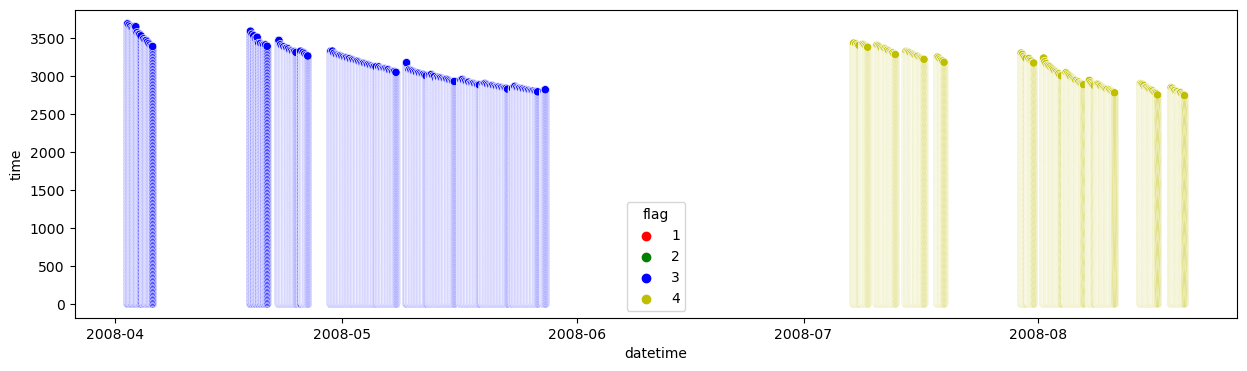

In [31]:
plt.figure(figsize=(15, 4))
sns.scatterplot(x = 'datetime', y = 'time', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- There hasn't been a continuos testing og charging of batteries throught the cycle.
- First three batteries (5,6,7) have been charged/tested synchronously whereas the 4th battery (B0018) is charges/tested post July 2008 with couple of breaks in between.
- The gerenal trend is more or less the same which is as time of battery's cycle charging decreases over a period of time.

### 3.Datetime w.r.t capacity

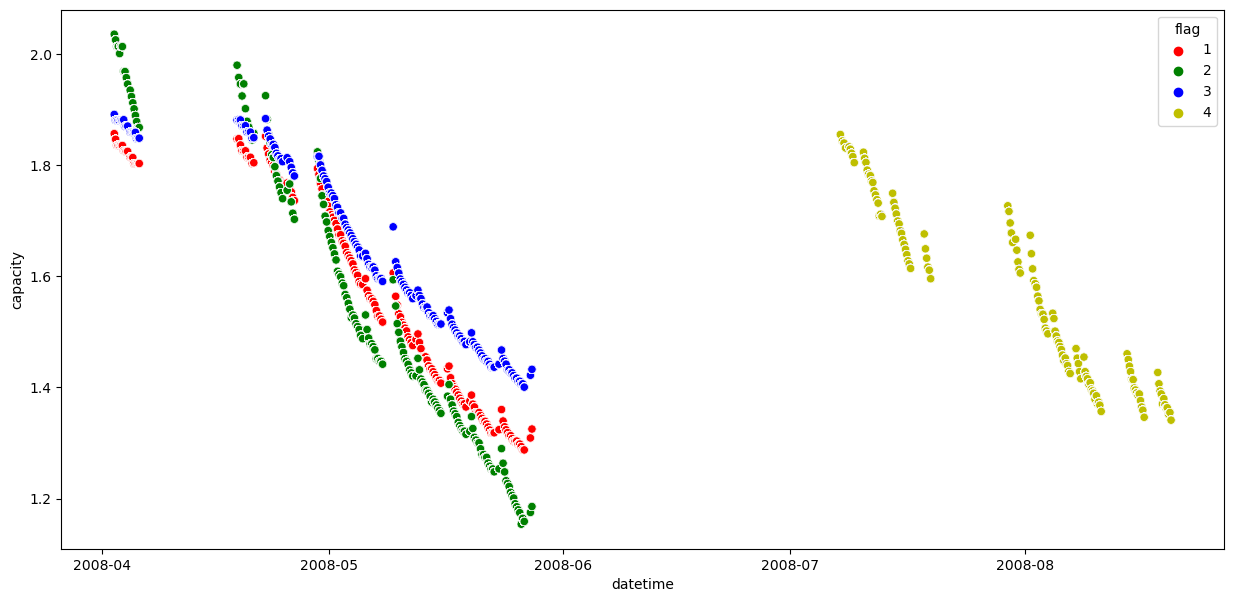

In [32]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'datetime', y = 'capacity', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- Capacity decreases over a period of time.
-  We can clearly see that, Battery (B0018) has been launched recently and is having average capacity over time.
- Capacity of Battery B0002 deteriorates the most over time whereas for blue it's most efficient in terms of capacity over a period of time.

### 4. Capacity w.r.t time

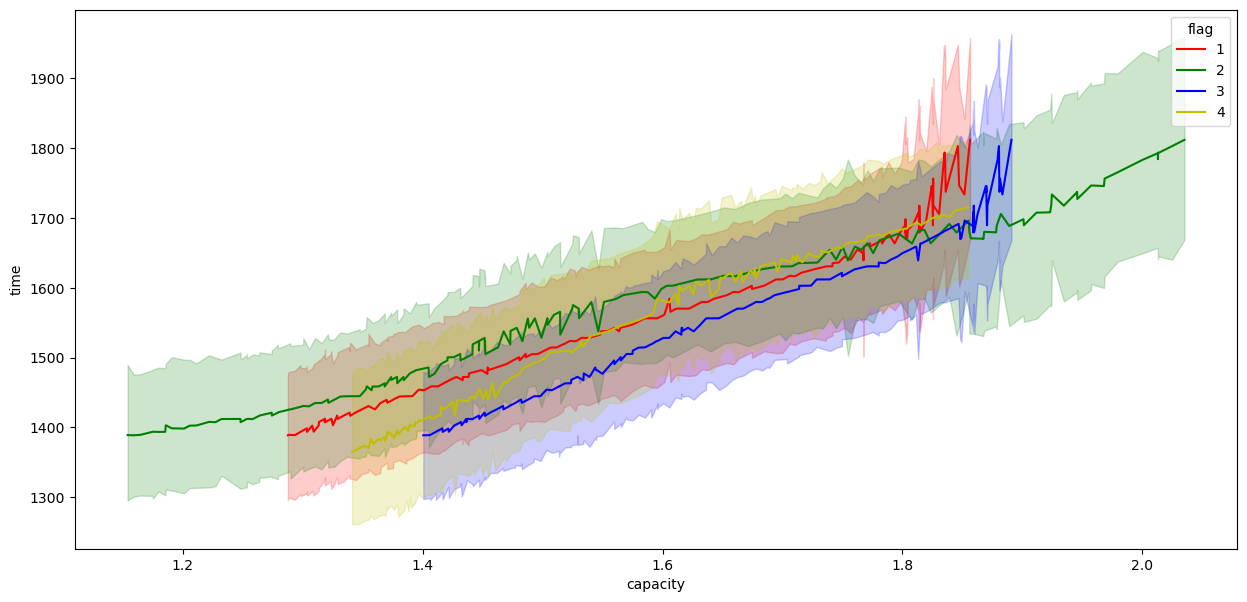

In [30]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'capacity', y = 'time', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- As time to charge the batteries is increasing, the capacity is also increasing on an average for all four batteries

### 5. Temperature w.r.t time

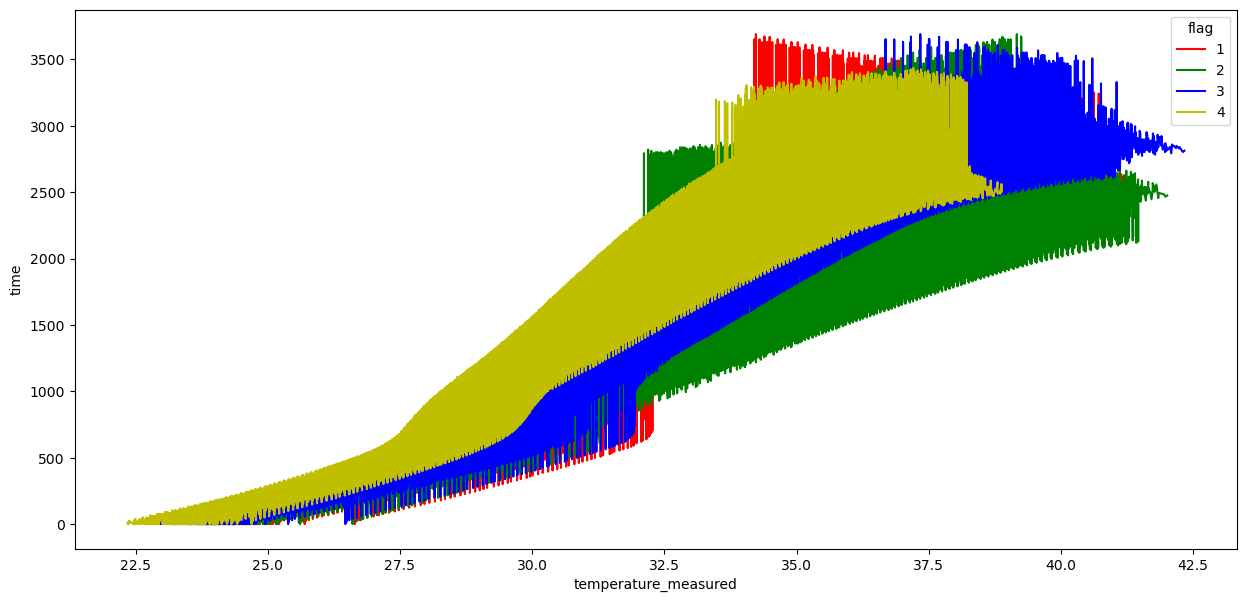

In [31]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'temperature_measured', y = 'time', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

-  As time increases for batteries, the depreciation increases because, temeperature_measured increases in every cycle of charging.
- As clearly visible, Batter (B0006) with flag 2 has max no. of outliers

### 6. Voltage measured w.r.t time

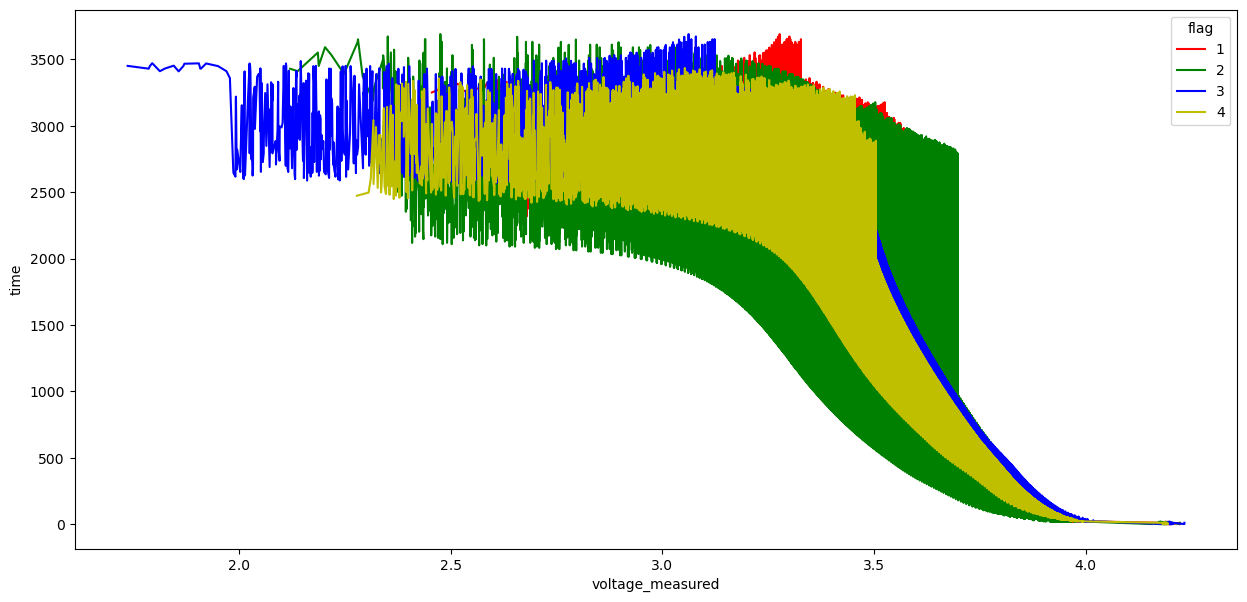

In [32]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'voltage_measured', y = 'time', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- As clearly visible, Batter (B0006) with flag 2 has max no. of outliers

### 7. Current measured w.r.t time

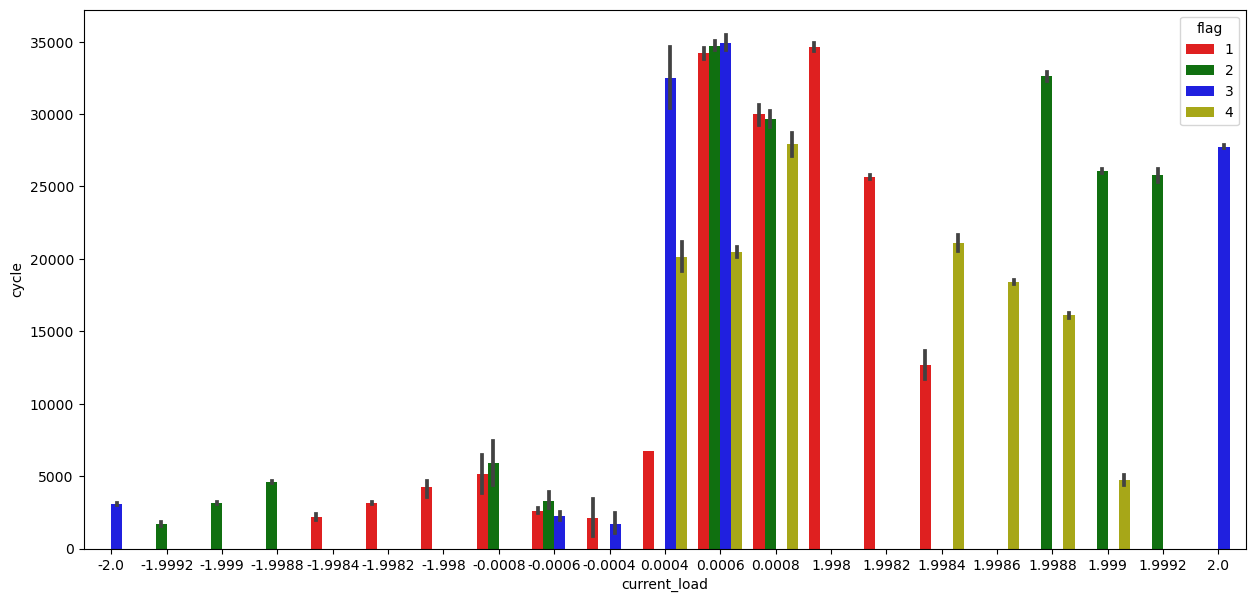

In [33]:
plt.figure(figsize=(15, 7))
sns.barplot(x = 'current_load', y = 'cycle', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- As clearly visible, Batter (B0006) with flag 2 has max no. of outliers

### 8. Correlation between various features

<!-- ![image.png](attachment:image.png) -->

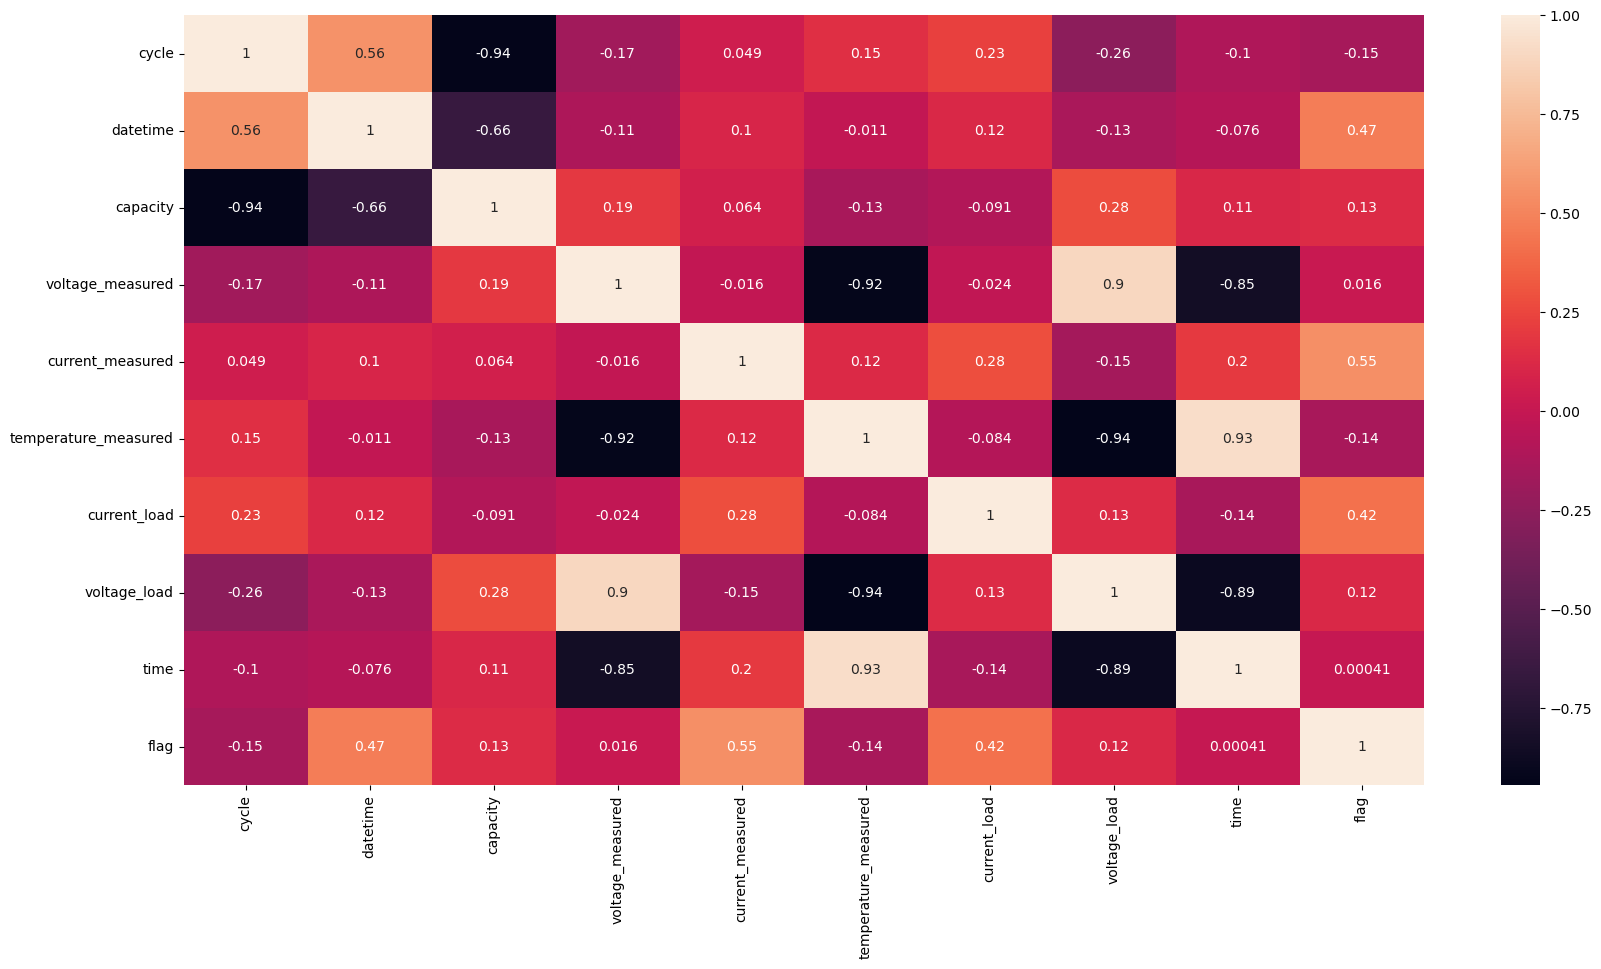

In [34]:
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(fuel_cells_df.corr(method = 'spearman'), annot = True)
plt.show()

- cycle & capacity -> negatively correlated.
- volatage load and voltage_measured -> negatively correlated.
- voltage_measured and time -> positively correlated.
- temperature and time -> positively correlated.

In [35]:
fuel_cells_df.shape

(185721, 10)

In [36]:
fuel_cells_df.drop_duplicates(keep = 'first', inplace = True)
fuel_cells_df.shape

(185721, 10)

In [37]:
fuel_cells_df.dropna(inplace = True)

In [38]:
fuel_cells_df.shape

(185721, 10)

In [33]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

# Visual analysis using traditional methods of anomaly detection( IQR and DBSCAN )

# 1. IQR based anomaly detection

In [34]:
num_cols_1 = ['capacity', 'voltage_measured','voltage_load']

In [35]:
num_cols_2 = ['current_measured','current_load']
temp = ['temperature_measured']

In [36]:
num_cols_3 = ['cycle','time']

In [37]:
Q1 = fuel_cells_df.quantile(0.25)
Q3 = fuel_cells_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

cycle                            23215.0
datetime                23 days 02:10:03
capacity                        0.315825
voltage_measured                0.278098
current_measured                0.021444
temperature_measured            5.850056
current_load                      0.0008
voltage_load                       0.308
time                            1542.688
flag                                 2.0
dtype: object


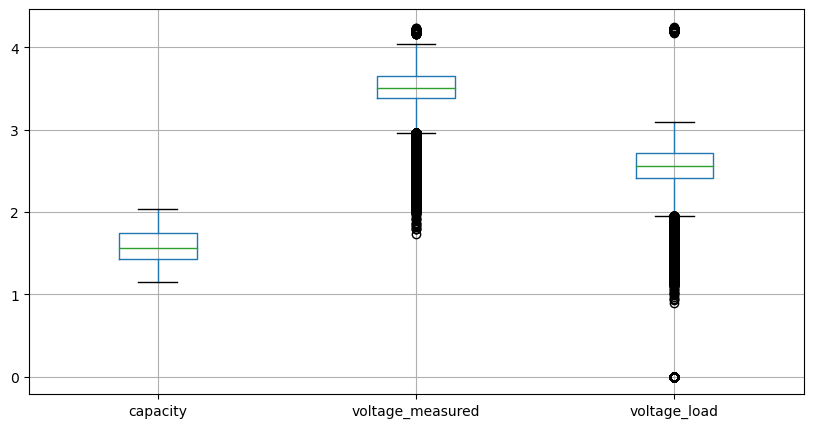

In [38]:
fuel_cells_df[num_cols_1].boxplot(figsize = (10,5))
plt.show()

#### - 'voltage_measured','voltage_load' have more no. of outliers (below the lower whisker)

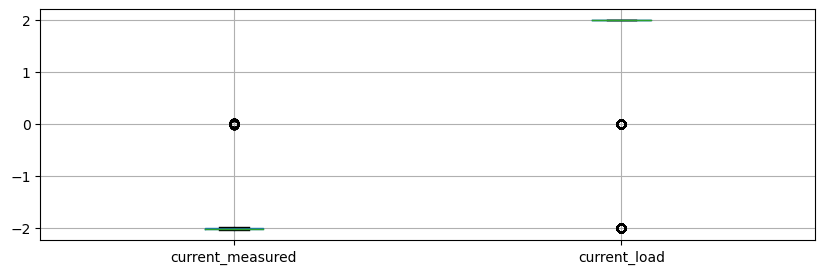

In [39]:
fuel_cells_df[num_cols_2].boxplot( figsize = (10,3))
plt.show()

#### - As the dataponts are less, the IQR range is very small, but some outliers are present for 'current_measured','current_load'

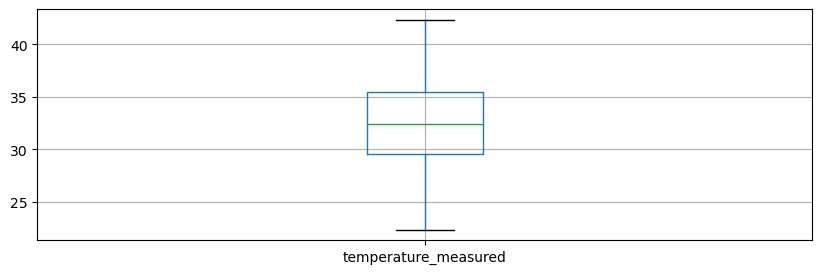

In [40]:
fuel_cells_df[temp].boxplot(figsize = (10,3))
plt.show()

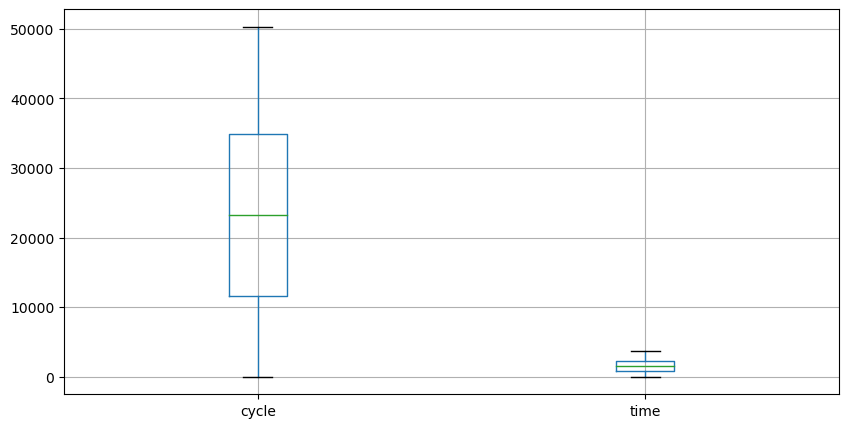

In [41]:
fuel_cells_df[num_cols_3].boxplot(figsize = (10,5))
plt.show()

- All other features are having very less outliers

In [42]:
num_cols = ['cycle','capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time']

In [43]:
fuel_cells_df.shape

(185721, 10)

In [44]:
fuel_cells_df1 = fuel_cells_df.copy()

### Outliers treatment using IQR based method

In [45]:
fuel_cells_df1 = fuel_cells_df1[~((fuel_cells_df1[num_cols] < (Q1 - 1.5*IQR)) | (fuel_cells_df1[num_cols] > (Q3 +1.5*IQR))).any(axis = 1)]
fuel_cells_df1 = fuel_cells_df1.reset_index(drop = True)

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [46]:
fuel_cells_df1.shape

(185721, 10)

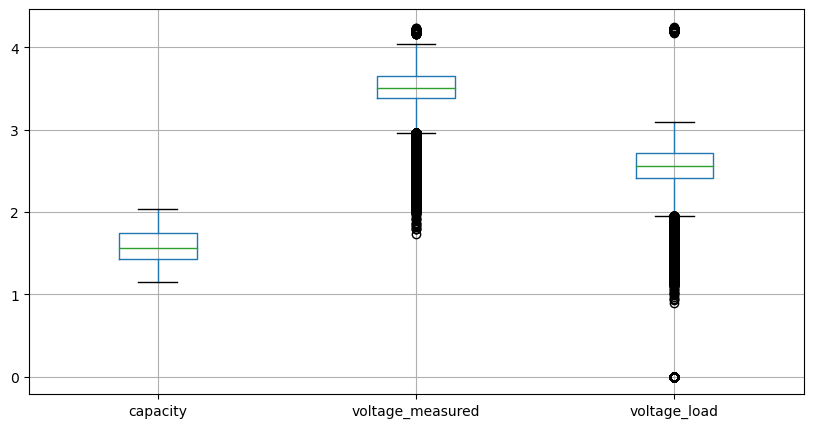

In [47]:
fuel_cells_df1[num_cols_1].boxplot(figsize = (10,5))
plt.show()

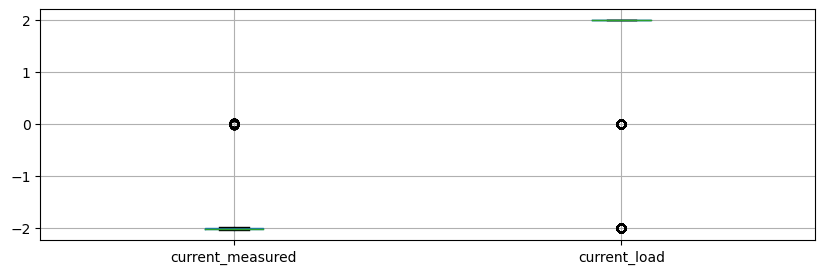

In [48]:
fuel_cells_df1[num_cols_2].boxplot(figsize = (10,3))
plt.show()

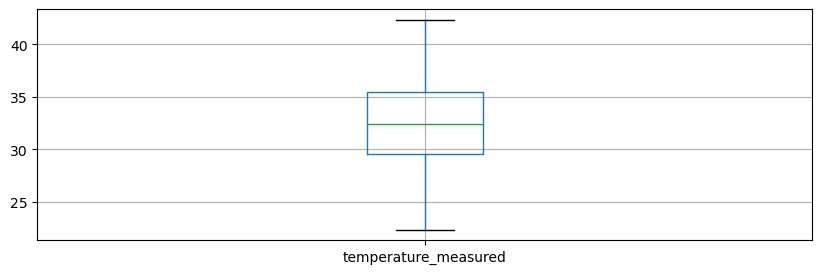

In [49]:
fuel_cells_df1[temp].boxplot(figsize = (10,3))
plt.show()

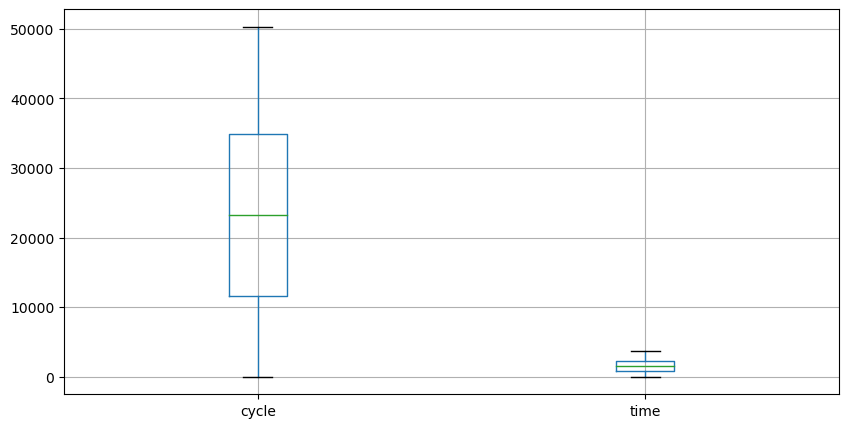

In [50]:
fuel_cells_df1[num_cols_3].boxplot(figsize = (10,5))
plt.show()

In [51]:
fuel_cells_df1.shape[0] - fuel_cells_df.shape[0]

0

- As we can see, total 37,766 datapoints are eliminated using IQR based method.
- This might contain some useful data as well, so it's better to treat/ detect outliers with some robust and SOTA methods of anomaly detection

In [52]:
# copy before mormalization and before datetime converson to int
fuel_cells_df_copy1 = fuel_cells_df.copy()

In [53]:
fuel_cells_df['datetime'] = fuel_cells_df['datetime'].astype('int64')
fuel_cells_df['datetime'].head()
# copy before mormalization and after datetime converson to int
fuel_cells_df_copy2 = fuel_cells_df.copy()

# 2. DBSCAN based anomaly detection

 -  As we know from above IQR method, that we have approx 37k outliers from 1.85 lac dataponts, I have carefully tried the hyperparameters (eps and minpts)
 - I have tried with several values of eps and minpts, and got to a conclusion that,with minpts  = 200 and eps = 0.5 we are getting the best results ( compared the results with sampling (taking 10k datapoints (later)) and bootstrapping with replacement )

In [54]:
# DBSCAn on entire dataset

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']



std_scaler = StandardScaler().fit(fuel_cells_df_copy2)
std_df = std_scaler.transform(fuel_cells_df_copy2)

dbsc = DBSCAN(eps = .5, min_samples = 200).fit(std_df)


labels = dbsc.labels_




In [56]:
out_df = fuel_cells_df_copy2.copy()
out_df['label'] = dbsc.labels_

In [ ]:
out_df['label'].value_counts()

In [ ]:
count_df = pd.DataFrame(data = out_df['label'].value_counts().values, columns = ['label_counts'])
count_df

In [ ]:
index_df = pd.DataFrame(data = out_df['label'].value_counts().index, columns = ['label_index'])
index_df

In [ ]:
label_counts_df = pd.concat([index_df,count_df], axis = 1)
label_counts_df

In [ ]:
out_df

In [ ]:
plt.figure(figsize=(15, 7))
sns.barplot(x =  'label_index', y = 'label_counts', data = label_counts_df)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

-  As we can see, when all features are considered, the datapoints corresponding to -1 (noisy data)  are 8009
- lets' further check with visualization and DBSCAN on other two features.
- It's running with very high time complexity and hence we have visualised on 10k samples.

### Visualization in lower dimention ( 2 features)

In [ ]:
# Let's plot two features data now for viz
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'time', y = 'temperature_measured', hue ='flag', data = out_df.sample(n = 10000, replace = True))
plt.xlabel('time of battery charging')
plt.ylabel('temperature_measured')
plt.show()

-  We can hardly see any outliers present when visualized with these two features.
- Lets cross check with some other two features

In [ ]:
# Let's plot different two features data now for viz
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'time', y = 'voltage_measured', hue ='flag', data = out_df.sample(n = 10000, replace = True))
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics


df = fuel_cells_df_copy2[['time','voltage_measured']].sample(n = 10000, replace = True)

std_scaler = StandardScaler().fit(df)
std_df = std_scaler.transform(df)

dbsc = DBSCAN(eps = .5, min_samples = 200).fit(std_df)


labels = dbsc.labels_

In [ ]:
out_df = df.copy()
out_df['label'] = dbsc.labels_

In [ ]:
out_df['label'].value_counts()

In [ ]:
out_df

In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(out_df['time'], out_df['voltage_measured'], c=out_df['label'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

- With DBSCAn, we are clearly able to see the cluster for noise points in purple.

#### - The total no. of outliers are 8009

In [ ]:
fuel_cells_df.info()

### Minmax Scaling of orginal data:

In [ ]:

cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']
mm_scaler = MinMaxScaler()

fuel_cells_df[cols] = mm_scaler.fit_transform(fuel_cells_df[cols])
fuel_cells_df.head()

# 3. Isolation Forest based Anomaly detection

The individual trees in an Isolation forest pick up a random feature and a random threshold and splits the data based on that. We expect the outliers to be found out at lower depth than normal points.

In [ ]:
fuel_cells_df['flag'].unique()

In [ ]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

flag_df = pd.DataFrame()
flag_df_final = pd.DataFrame()
for j in fuel_cells_df['flag'].unique():
    contamination_arr = [0.01, 0.02, 0.03, 0.04]
    flag_df = fuel_cells_df[fuel_cells_df['flag'] == j]
    for i in contamination_arr:
        model = IsolationForest(n_estimators = 200, max_samples = 'auto', contamination = i, random_state = 42)
        flag_df['anomaly_score'+'_'+str(i)] = model.fit_predict(flag_df)
        flag_df['scores'+'_'+str(i)] = model.decision_function(flag_df[flag_df.columns.difference(['anomaly_score'+'_'+str(i)])])
    flag_df_final = pd.concat([flag_df,flag_df_final])

In [ ]:
# flag_df

In [ ]:
flag_df_final['anomaly_score_0.01'].value_counts(ascending= True)

In [ ]:
for i in contamination_arr:
    print(f'Anomalies with contamination {i}:',len(flag_df_final[flag_df_final['anomaly_score'+'_'+str(i)] == -1]))

<!-- ![image.png](attachment:image.png) -->

In [ ]:
## Data before normalization merging with new:

fuel_cells_df_final = pd.concat([fuel_cells_df_copy2, flag_df_final.drop(columns=fuel_cells_df.columns)], axis = 1)

In [ ]:
df_final_copy = fuel_cells_df_final.copy()

In [ ]:
fuel_cells_df_final

## Plotting scores to visualize the scores given to the data

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(x = 'scores_0.01',hue = 'flag', palette=['r','g','b','y'], data = df_final_copy, bins = 100, kde = True)
fig.show()

- flag 2 is having maximum spread in the scores, which again confirms that Battery 2 is having max no. of outliers

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(x = 'scores_0.01',hue = 'anomaly_score_0.01', palette=['r','b'], data = df_final_copy, bins = 100, kde = True)
fig.show()

In [ ]:
df_final_copy[df_final_copy['anomaly_score_0.01']==-1]['flag'].value_counts()

In [ ]:
df_final_copy[df_final_copy['anomaly_score_0.04']==-1]['flag'].value_counts()

In [ ]:
data = df_final_copy[df_final_copy['anomaly_score_0.01']==-1]

In [ ]:
wd = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2)]
len(wd)

In [ ]:
# Thresholding on scores ( < 0.04)

wd2 = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.01']<-0.04)]
len(wd2)

In [ ]:
# Thresholding on scores ( < 0.05)

wd3 = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.01']<-0.05)]
len(wd3)

In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['capacity'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['temperature_measured'], c = 'blue', marker = "*")

plt.scatter(wd['capacity'], wd['temperature_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['capacity'], wd2['temperature_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['capacity'], wd3['temperature_measured'], c = 'black', marker = 'o')

plt.xlabel('capacity')
plt.ylabel('temperature_measured')
plt.show()

- Batteries with much higher capacities and much lower capacities but having minimum temperature measured are having most critical number of outliers
- WHereas as the batteries with least temperature measured are having more number of outliers.

In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['cycle'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['temperature_measured'], c = 'blue', marker = "*")

plt.scatter(wd['cycle'], wd['temperature_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['cycle'], wd2['temperature_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['cycle'], wd3['temperature_measured'], c = 'black', marker = 'o')

plt.xlabel('cycle')
plt.ylabel('temperature_measured')
plt.show()

- The batteries with least temperature measured are having more number of outliers.

In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['time'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['voltage_measured'], c = 'blue', marker = "*")

plt.scatter(wd['time'], wd['voltage_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['time'], wd2['voltage_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['time'], wd3['voltage_measured'], c = 'black', marker = 'o')

plt.xlabel('time')
plt.ylabel('voltage_measured')
plt.show()

- Batteries datapoints which are producing maximum voltages with barely minimum charging time are ceratinly outliers/anamolies.
- Also, with least contamination, the Batteries datapoints which requires maximum time to charge ceratinly outliers/anamolies.

### Anamolies with increased contamination %

In [ ]:
# Testing with multiple values such as with  anomaly_score_0.04

wd = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2)]
wd2 = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.04']<-0.04)]
wd3 = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.04']<-0.05)]


In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.04'] == 1) & (df_final_copy['flag'] == 2)]['time'],
           df_final_copy[(df_final_copy['anomaly_score_0.04'] == 1) & (df_final_copy['flag'] == 2)]['voltage_measured'], c = 'blue', marker = "*")

plt.scatter(wd['time'], wd['voltage_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['time'], wd2['voltage_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['time'], wd3['voltage_measured'], c = 'black', marker = 'o')

plt.xlabel('time')
plt.ylabel('voltage_measured')
plt.show()

- As it's clearly visible , if we increase the contamination % of outliers to 4 % , it's able to classify the visually seen anamolies as outliers as compared to contamionation of 1 %
- Also, with max contamination of 4%, the Batteries datapoints which requires maximum time to charge and whose voltages are low are ceratinly outliers/anamolies.

In [ ]:
flags_arr = [1,2,3,4]
contamination_arr = [0.01,0.02,0.03,0.04]

In [ ]:
for i in flags_arr:
    for j in contamination_arr:
        wd = df_final_copy.loc[(df_final_copy['anomaly_score'+'_'+str(j)] == -1) & (df_final_copy['flag'] == i)]
        wd2 = df_final_copy.loc[(df_final_copy['anomaly_score'+'_'+str(j)] == -1) & (df_final_copy['flag'] == i) & (df_final_copy['scores'+'_'+str(j)]<-0.04)]
        wd3 = df_final_copy.loc[(df_final_copy['anomaly_score'+'_'+str(j)] == -1) & (df_final_copy['flag'] == i) & (df_final_copy['scores'+'_'+str(j)]<-0.06)]

        plt.figure(figsize=(8, 6))
        plt.scatter(df_final_copy[(df_final_copy['anomaly_score'+'_'+str(j)] == 1) & (df_final_copy['flag'] == i)]['capacity'],
                   df_final_copy[(df_final_copy['anomaly_score'+'_'+str(j)] == 1) & (df_final_copy['flag'] == i)]['temperature_measured'], c = 'blue', marker = "*")

        plt.scatter(wd['capacity'], wd['temperature_measured'], c = 'orange', marker = 'o')
        plt.scatter(wd2['capacity'], wd2['temperature_measured'], c = 'red', marker = 'o')
        plt.scatter(wd3['capacity'], wd3['temperature_measured'], c = 'black', marker = 'o')

        plt.xlabel('capacity')
        plt.ylabel('temperature_measured')
        plt.title('Battery with flag ' + str(i)+ ' having contamination of '+str(j))
        plt.show()

- The batteries with least temperature measured are having more number of outliers.
- Batteries with much higher capacities and much lower capacities but having minimum temperature measured are having most critical number of outliers
- WHereas as the batteries with least temperature measured are having more number of outliers.
- As we go on increase the contamination %, we are getting more number of datapoints classified as extreme outliers.

# 4. Local Outlier Factor(LOF) based Anomaly detection

In [ ]:
lof_df = fuel_cells_df_copy2.copy()

In [ ]:
fuel_cells_df_copy2

In [ ]:
n_neighbors = [5, 20]
contamination_arr = [0.01,0.04]
flags_arr = [1,2,3,4]

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
for f in flags_arr:
    for n in n_neighbors:
        for c in contamination_arr:
            # model specification
            model1 = LocalOutlierFactor(n_neighbors = n, metric = "manhattan", contamination = c)
            # model fitting
            y_pred = model1.fit_predict(fuel_cells_df_copy2)
            # filter outlier index
            outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
            # filter outlier values
            outlier_values = fuel_cells_df_copy2.iloc[outlier_index]
            # plot data
            plt.scatter(fuel_cells_df_copy2["capacity"], fuel_cells_df_copy2["temperature_measured"], color = "b", s = 65)
            # plot outlier values
            plt.scatter(outlier_values["capacity"], outlier_values["temperature_measured"], color = "r")
            plt.xlabel('capacity')
            plt.ylabel('temperature_measured')
            plt.title('Battery with flag ' + str(f)+ ' with n_neighbors = '+ str(n)+' having contamination of '+str(c))
            plt.show()

- In LOF, the hypermeters used are n_neighbors = [5, 20] and contamination_ = [0.01,0.04].
- Almost 7429 datapoints are getting classified as outliers using maximum nearest neigbors (20) and with higesht contamination percentage of 4%.
- With least nearest neigbors and least contamination percentage, we are getting less no. of outliers specifically in the mid-battery capacity range (1.4-1.6) having least and maximum temperature measured. This can be informed to subject matter expert and thus can be validated before removal.


In [ ]:
len(y_pred)

In [ ]:
fuel_cells_df_copy2

In [ ]:
y_pred_df = pd.DataFrame(data=y_pred,columns=['y_pred'])
fuel_cells_df_copy2_final_lof = pd.concat([fuel_cells_df_copy2,y_pred_df],axis = 1)
fuel_cells_df_copy2_final_lof

In [ ]:
# No. of outliers when we are considering the highest contamoination i.e 4 %

fuel_cells_df_copy2_final_lof[fuel_cells_df_copy2_final_lof['y_pred'] == -1]

In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(fuel_cells_df_copy2_final_lof['time'], fuel_cells_df_copy2_final_lof['voltage_measured'], c=fuel_cells_df_copy2_final_lof['y_pred'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

- I have validated visually in lower dimension with above hyperparameters but the performance is less acuurate than Isolation Forest but more accurate than other methods.

# 5. Elliptical Envelope based Anomaly detection

In [ ]:
eliptical_df = fuel_cells_df_copy2.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']
scaler = StandardScaler()

eliptical_df[cols] = scaler.fit_transform(eliptical_df[cols])
eliptical_df.head()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test= train_test_split(eliptical_df, test_size=0.33, random_state=42)

In [ ]:
# convert tarin dataframe to arrays
data = X_train[cols].values

In [ ]:

from sklearn.covariance import EllipticEnvelope
# instantiate model
model1 = EllipticEnvelope(contamination = 0.1)
# fit model
model1.fit(data)

In [ ]:
# convert test dataframe to arrays
# new data for prediction (data needs to be in arrays)
new_data = X_test[cols].values

In [ ]:

# predict on new data
pred1 = model1.predict(new_data)
print(pred1)

In [ ]:
len(new_data)

In [ ]:
len(pred1)

In [ ]:
pred_df = pd.DataFrame(data=pred1,columns=['pred1'])
fuel_cells_df_copy2_final_eliptical = pd.concat([X_test,pred_df],axis = 1)


In [ ]:
pred_df

In [ ]:
X_test

In [ ]:
fuel_cells_df_copy2_final_eliptical[fuel_cells_df_copy2_final_eliptical['pred1'] == -1].shape

In [ ]:
# predict on all data
all_data = eliptical_df[cols].values
pred2 = model1.predict(all_data)
print(pred2)

In [ ]:
len(pred2)

In [ ]:
len(all_data)

In [ ]:
pred_df_all = pd.DataFrame(data=pred2,columns=['pred2'])
final_eliptical = pd.concat([fuel_cells_df_copy2,pred_df_all],axis = 1)
final_eliptical

In [ ]:
final_eliptical[final_eliptical['pred2'] == -1]

In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(final_eliptical['time'], final_eliptical['voltage_measured'], c=final_eliptical['pred2'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(fuel_cells_df_copy2_final_lof['capacity'], fuel_cells_df_copy2_final_lof['temperature_measured'], c=fuel_cells_df_copy2_final_lof['y_pred'])
plt.xlabel('capacity')
plt.ylabel('temperature_measured')
plt.show()

# Comparison of results from the above algorithms:

#### I have tried 5 methods for anamoly detection:
- 1. IQR based
- 2. DBSCAN (density based)
- 3. Isolation Forest ()
- 4. Local Outlier Factor (LOF)
- 5. Elliptical Envelope


### 1. IQR based
- As we have see, total **37,766 datapoints (20.13% data) are tagged as outliers** using IQR based method.
- This data is huge and might contain some useful information as well, so it's better to treat/ detect outliers with some robust and SOTA methods of anomaly detection. ( worst performer )

### 2. DBSCAN (density based)
- With proper hit and trial for finding the best hyperparameters (eps and minpts) I got **eps = 0.5, min_samples = 200**. With this, I was able to detect **8009 datapoints as outliers**. Have validated visually in lower dimension with above hyperparameters.

### 3. Isolation Forest
- Anomalies with contamination **1%, 2%, 3%, 4% are 1858, 3716, 5573, 7431 respectievly**.
- Even with the least contamination %, we are able to get the exact no. of outliers which I have validated visually in lower dimension with different different set of features.
- However, **as per the subject matter expert we can still get it validated** if certain points are anamlalies or not, but we are getting good match.
- We can easily further classify the outliers into **good, average and extreme anaamloes.**
- As we go on increasing the contamination %, we are getting more number of datapoints classified as extreme outliers.

### 4. Local Outlier Factor (LOF)
- In LOF, the hypermeters used are n_neighbors = [5, 20] and contamination_ = [0.01,0.04].
- Almost **7429 datapoints are getting classified as outliers** using **maximum nearest neigbors (20) and with higesht contamination percentage of 4%.**
- I have validated visually in lower dimension with above hyperparameters but the performance is less acuurate than Isolation Forest but more accurate than other methods.
- With least nearest neigbors and least contamination percentage, we are getting less no. of outliers specifically in the mid-battery capacity range (1.4-1.6) having least and maximum temperature measured. This can be informed to subject matter expert and thus can be validated before removal.
- Along with extreme endpoints, the mid level inliers are also considered as outliers upon increasing contamination% upto 4% in bivariate analysis of temperature vs capacity

### 5. Elliptical Envelope
- Providing contamination as hyperparametr, we are able to get **18387 data points labelled (-1) i.e outliers.**
- Along with extreme endpoints, the mid level inliers are also considered as outliers even in lower contamination% of 1 % in bivariate analysis of temperature vs capacity

### Final performance conclusions:
#### Isolation Forest >>  Local Outlier Factor (LOF) >  DBSCAN (density based) >  Elliptical Envelope >> IQR based

# Actionable Insights & Recommendations:

- Capacity of batteries decrease as no. of cycles of battery usage increases. Also **Capacity decreases over a period of time.**
- Battery B0006 (2) is having the largest capacity when it's new. Whereas B0018 and B0007 is having the least capacity when it's unused.
- Over a period of time, **B0006 shows much more deteriorating trend** than others , whereas **B0007 has the most efficient capacity**. Also, **Battery (B0006) with flag 2 has max no. of outliers**. This might be the primary reason for Battery 2's worst performance. **The classified anamolous datapoints should be highlighted** to the management after required **scrutiny from SMEs** and thus the team can take **proper action on improvement** with given feature's values.
- There hasn't been a continuos testing of charging of batteries throught the cycle. First three batteries (5,6,7) have been charged/tested synchronously whereas the 4th battery (B0018) is charged/tested post July 2008 with couple of breaks in between.
- The general trend is more or less the same which is as time of battery's cycle charging decreases over a period of time.
- We can clearly see that, **Battery (B0018) has been launched recently** and is having average capacity over time.
- Capacity of Battery B0002 deteriorates the most over time whereas for blue it's most efficient in terms of capacity over a period of time.
- As time to charge the batteries is increasing, the capacity is also increasing on an average for all four batteries
- **As time increases for batteries, the depreciation increases** because, temeperature_measured increases in every cycle of charging.
- Batteries with **much higher capacities and much lower capacities but having minimum temperature measured** are having most critical number of outliers. These can be checked with subject matter expert and then the **NASA  team can work upon finding the exact root cause behind this behaviour**
- On an average, The batteries with **least temperature measured are having more number of outliers.**
- Batteries datapoints which are producing **maximum voltages with barely minimum charging time are ceratinly outliers/anamolies.**
- Also, with least contamination, the Batteries datapoints which requires maximum time to charge ceratinly outliers/anamolies.
- As it's clearly visible , if we increase the contamination % of outliers to 4 % , it's able to classify the visually seen anamolies as outliers as compared to contamionation of 1 %
- Also, with max contamination of 4%, the Batteries datapoints which **requires maximum time to charge and whose voltages are low are ceratinly outliers/anamolies.**
- As we go on **increase the contamination %**, we are getting **more number of datapoints classified as extreme outliers.**
- With least nearest neigbors and least contamination percentage, we are getting less no. of outliers specifically in the **mid-battery capacity range (1.4-1.6) having least and maximum temperature measured**. This can be informed to subject matter expert and thus can be validated before removal.


# Please do share your valuable comments and please UPVOTE the notebook if you like it!!